# Кластеризация временных рядов

## Цель:
найти похожие группы временных рядов

## Для чего:
- финансовый анализ (например, диверсификация портфеля);
- поиск аномальных событий.

## Какие сложности:
- похожие участки временного ряда (патерны) могут находится в разных местах;
- временные ряды могут быть разной длинны;
- дискретизация временных рядов может быть различна.

## Пути решения задач:

1. Классический KMeans и другие класические алгоритмы кластеризации
    - на сырых данных, приведенных к одной длине
    - на признаках, извлеченных из временных рядов
2. Dynamic Time Warping (DTW)
    - позволяет работать с рядами разной длины
    - умеет находить паттерны в разных участках
3. Time Series Embeddings - нейросеть с последующей кластеризацчией результатов (за пределами данного курса)
    

# Dynamic Time Warping

Хорошее объяснение происходящего - https://tslearn.readthedocs.io/en/stable/user_guide/dtw.html#dtw-softdtw


<table><tr>
<td> <img src="https://upload.wikimedia.org/wikipedia/commons/9/97/Two_repetitions_of_a_walking_sequence_of_an_individual_recorded_using_a_motion-capture_system.gif" alt="Drawing" style="width: 500px;"/> </td>
<td> <img 
<td> <img src="https://upload.wikimedia.org/wikipedia/commons/6/69/Euclidean_vs_DTW.jpg" alt="Drawing" style="width: 300px;"/> </td>
</tr></table>


## Распознавание человеческой деятельности с использованием набора данных со смартфонов (Human Activity Recognition Using Smartphones Data Set - HAR)

Данный датасет очень часто используют для демонстрационного примера по поиску кластеризации временных рядов.

Эксперименты проводились с группой из 30 добровольцев в возрасте от 19 до 48 лет. 
Каждый человек выполнял шесть действий:
- ходил - WALKING;
- ходил по лестнице вверх - WALKING_UPSTAIRS;
- ходил по лестнице вниз - WALKING_DOWNSTAIRS;
- сидел - SITTING;
- стоял - STANDING; 
- лежал - LAYING,
надев на поясе смартфон (Samsung Galaxy S II). 

Используя встроенный акселерометр и гироскоп, фиксировалось 3-осевое линейное ускорение и 3-осевую угловую скорость с постоянной частотой 50 Гц. 

Эксперименты были записаны на видео, чтобы вручную маркировать данные. Полученный набор данных был случайным образом разделен на два набора, из которых 70% добровольцев были выбраны для генерации обучающих данных и 30% тестовых данных.

[Набор данных ...](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Сборка данных шаг 1

In [8]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

data = load_file("UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt")
print(data.shape)

(7352, 128)


### Сборка данных шаг 2

In [9]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
    loaded = []
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded
 
# load the total acc data
train_filename = [
        'body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
        'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
        'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt'
    ]

test_filename = [
        'body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
        'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
        'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt'
    ]

train_signal = load_group(train_filename, prefix='UCI HAR Dataset/train/Inertial Signals/')
train_label = load_group(['y_train.txt'], prefix='UCI HAR Dataset/train/').reshape(-1)

test_signal = load_group(test_filename, prefix='UCI HAR Dataset/test/Inertial Signals/')
test_label = load_group(['y_test.txt'], prefix='UCI HAR Dataset/test/').reshape(-1)

activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

In [10]:
# Перемешаем данные, на всякий случай :)

## Вариант 1 
randomize = np.arange(len(train_signal))
np.random.shuffle(randomize)
train_signal_shuffle = train_signal[randomize]
train_label_shuffle  = train_label[randomize]

## Вариант 2
from sklearn.utils import shuffle
test_signal_shuffle, test_label_shuffle = shuffle(test_signal, test_label, random_state=0)

In [11]:
# Важно разобраться как это работает swapaxes и reshape !!!
X_train = train_signal_shuffle.swapaxes(2,1).reshape(train_signal_shuffle.shape[0], -1)
X_test  = test_signal_shuffle.swapaxes(2,1).reshape(test_signal_shuffle.shape[0], -1)
y_train = train_label_shuffle
y_test  = test_label_shuffle

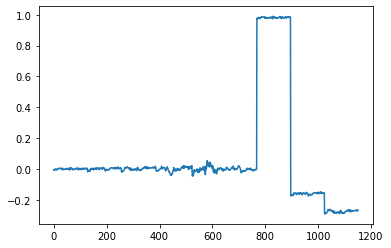

In [12]:
# пример выборки "разбитой" на 9 составных частей по 128 отсчетов
k = 1
plt.plot(X_train[k]);

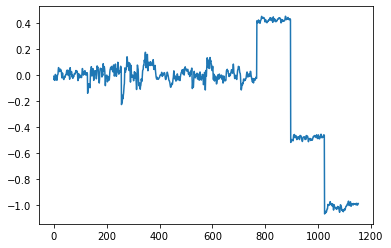

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_ss = scaler.transform(X_train)
X_test_ss  = scaler.transform(X_test)

# Нужно ли в дданном случае стандартизировать значения большой вопрос ...
# X_train_ss = X_train
# X_test_ss  = X_test

plt.plot(X_train_ss[k]);

100%|█████████████████████████████████████████████| 9/9 [00:10<00:00,  1.15s/it]


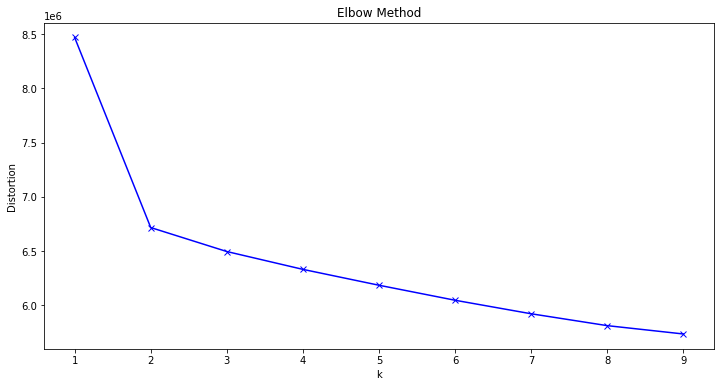

In [14]:
from tqdm import tqdm
from sklearn.cluster import KMeans

def plot_distortions(k_range, data):
    distortions = []
    K = k_range
    for k in tqdm(K):
        kmeans_model = KMeans(n_clusters=k)
        kmeans_model.fit(data)
        distortions.append(kmeans_model.inertia_)

    plt.figure(figsize=(12,6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    plt.show()

    
plot_distortions(range(1,10), X_train_ss)

In [15]:
kmeans_model = KMeans(n_clusters=6)
kmeans_model.fit(X_train_ss)
clusters = kmeans_model.predict(X_train_ss)
clusters = clusters+1
clusters

array([3, 1, 1, ..., 6, 6, 4], dtype=int32)

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity = 10, 
            random_state = 123)

tsne_transformed = tsne.fit_transform(X_train_ss)

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


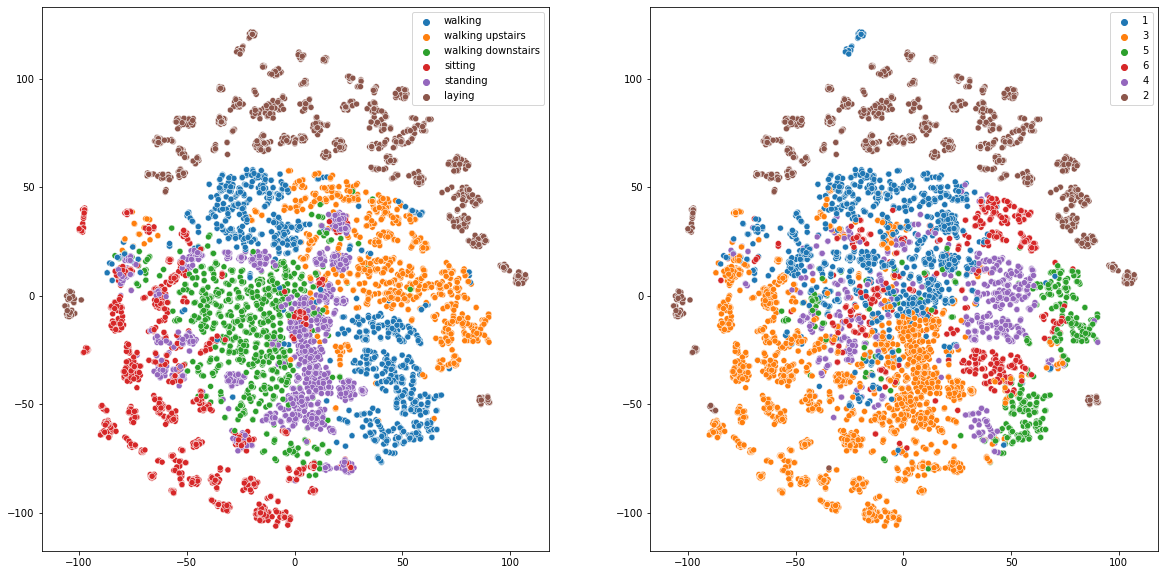

In [24]:
import seaborn as sns
palette = sns.color_palette(n_colors=6)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(data=tsne_transformed, x=tsne_transformed[:,0], y=tsne_transformed[:,1], 
                hue = np.vectorize(activities_description.get)(y_train), 
                hue_order = list(activities_description.values()),                
                ax = ax[0],  palette=palette);

sns.scatterplot(data=tsne_transformed, x = tsne_transformed[:,0], y=tsne_transformed[:,1], 
                hue = clusters, ax = ax[1], palette=palette, 
                hue_order = [1,3,5,6,4,2]);

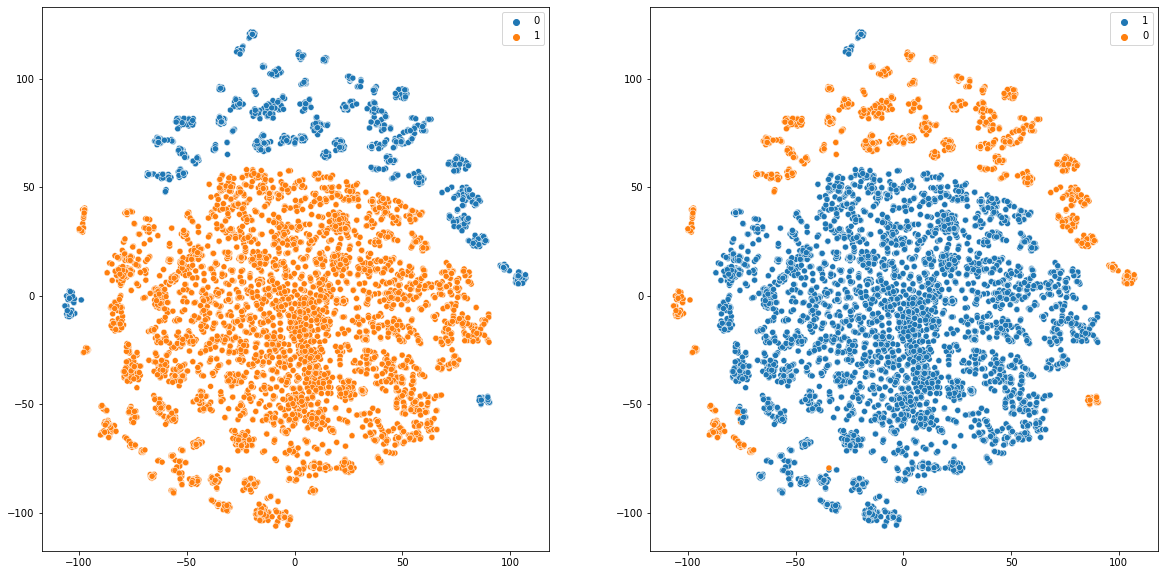

In [25]:
kmeans_model = KMeans(n_clusters=2)
kmeans_model.fit(X_train_ss)
clusters2 = kmeans_model.predict(X_train_ss)
clusters2 = clusters2

import seaborn as sns

y_cls = np.where(y_train > 5, 0, 1)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(data=tsne_transformed, x=tsne_transformed[:,0], y=tsne_transformed[:,1], 
                hue = y_cls, 
                ax = ax[0],  
                palette="tab10");
sns.scatterplot(data=tsne_transformed, x = tsne_transformed[:,0], y=tsne_transformed[:,1], 
                hue = clusters2, 
                ax = ax[1], 
                palette="tab10", 
                hue_order = [1,0]);

In [26]:
## KMeans с евклидовом пространстве только в 6 мерном 

In [27]:
## Очччччеееннннь долго. Внимание тут решается задача сразу в 6 мерном пространстве.
from tslearn.clustering import TimeSeriesKMeans

# Ниже загрузка результата Pickle
# km_dtw = TimeSeriesKMeans(n_clusters=6, metric="dtw", verbose=True, n_jobs=6, max_iter = 10)
# km_dtw.fit(train_signal_shuffle)

In [28]:
import pickle

####  Запись DTW ОСТОРОЖНО !!! НЕ ВЫПОЛНЯТЬ pickle.dump!!!
# with open("ts_km_dtw.pickle", 'wb') as f:
#     pickle.dump(km_dtw, f)

with open("ts_km_dtw.pickle", 'rb') as f:
    ts_kmeans_dtw = pickle.load(f)    

In [29]:
label_dtw = ts_kmeans_dtw.predict(train_signal_shuffle)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.7s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:    0.7s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:    0.7s
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done 8438 tasks      | elapsed:    1.5s
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed:    1.6s
[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed:  

In [30]:
# Ниже загрузка результата Pickle
# km_softdtw = TimeSeriesKMeans(n_clusters=6, metric="softdtw", verbose=True, n_jobs=6, max_iter = 10)
# km_softdtw.fit(train_signal_shuffle)

In [31]:
####  Запись SoftDTW ОСТОРОЖНО !!! НЕ ВЫПОЛНЯТЬ pickle.dump!!!
# with open("ts_km_softdtw.pickle", 'wb') as f:
#     pickle.dump(km_dtw, f)

with open("ts_km_softdtw.pickle", 'rb') as f:
    ts_kmeans_softdtw = pickle.load(f)

In [32]:
label_softdtw = ts_kmeans_softdtw.predict(train_signal_shuffle)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed:    0.6s
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed:    0.7s
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done 8438 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed:  

In [33]:
import pandas as pd
left = pd.DataFrame(label_dtw)
right = pd.DataFrame(label_softdtw)
df = pd.merge(left,right, left_index=True, right_index=True, how ='outer', indicator = True)
display(df.head(5))
df[df['_merge']!='both']

,0_x,0_y,_merge
0,5,5,both
1,5,5,both
2,5,5,both
3,0,0,both
4,2,2,both


,0_x,0_y,_merge


/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


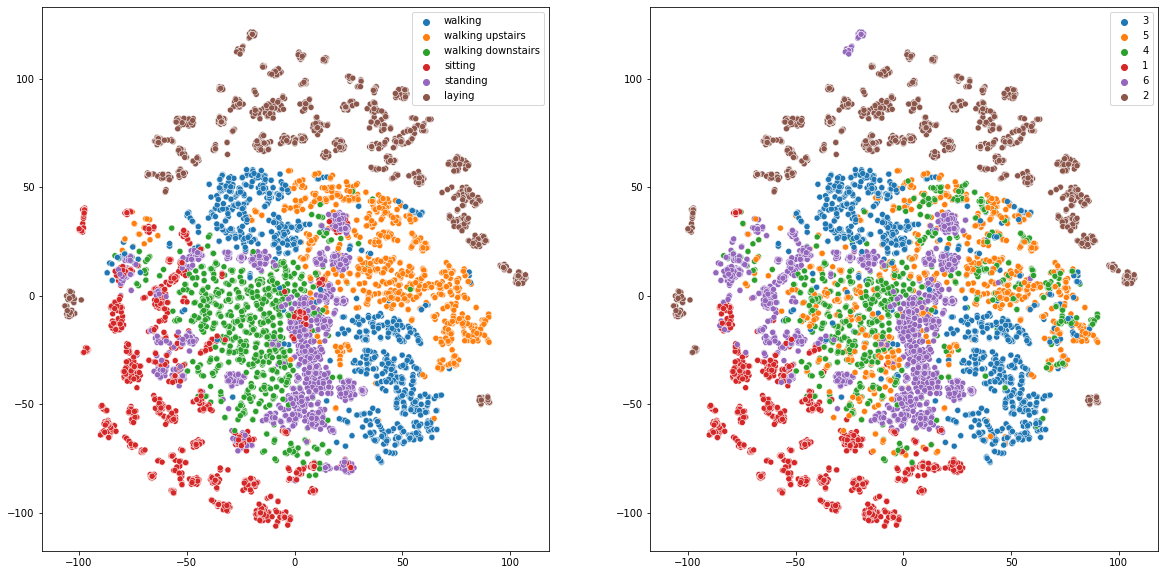

In [34]:
palette = sns.color_palette(n_colors=6)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(data=tsne_transformed, x=tsne_transformed[:,0], y=tsne_transformed[:,1], 
                hue = np.vectorize(activities_description.get)(y_train), 
                hue_order = list(activities_description.values()), 
                ax = ax[0],  palette=palette);
sns.scatterplot(data=tsne_transformed, x = tsne_transformed[:,0], y=tsne_transformed[:,1], 
                hue = label_dtw+1, 
                ax = ax[1], palette=palette, 
                hue_order = [3,5,4,1,6,2]
               );

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


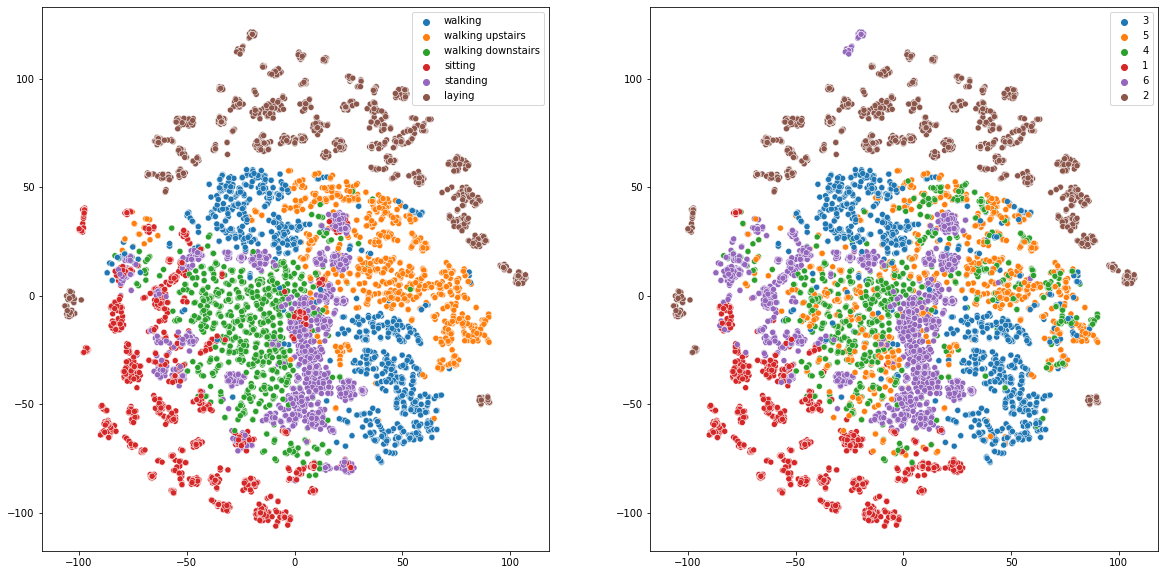

In [35]:
# выводить смысла нет, так как у меня нет разницы

palette = sns.color_palette(n_colors=6)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(data=tsne_transformed, x=tsne_transformed[:,0], y=tsne_transformed[:,1], 
                hue = np.vectorize(activities_description.get)(y_train), 
                hue_order = list(activities_description.values()),
                ax = ax[0],  palette=palette);
sns.scatterplot(data=tsne_transformed, x = tsne_transformed[:,0], y=tsne_transformed[:,1], 
                hue = label_softdtw+1, 
                ax = ax[1], palette=palette, 
                hue_order = [3,5,4,1,6,2]
               );

# Ловушка мультиколлениарности во временных рядах

In [60]:
import tsfel
fs = 100
cfg_file = tsfel.get_features_by_domain('temporal')

EXTRACT = True

if EXTRACT:
    X_train_fs = tsfel.time_series_features_extractor(cfg_file, train_signal_shuffle, fs=fs)
    X_train_fs.to_csv('X_train_tsfel.csv')
else:
    X_train_fs = pd.read_csv('X_train_tsfel.csv', index_col=0)

*** Feature extraction started ***



*** Feature extraction finished ***


In [63]:
from sklearn.feature_selection import VarianceThreshold
# Убираем фичи с высокой корреляцией
corr_features = tsfel.correlated_features(X_train_fs)
X_train_drop = X_train_fs.drop(corr_features, axis=1)

# Убираем фичи с низкой дисперсией
selector = VarianceThreshold()
X_train_drop = selector.fit_transform(X_train_drop)


In [64]:
# Ниже загрузка результата Pickle
# km_softdtw_drop = TimeSeriesKMeans(n_clusters=6, metric="softdtw", verbose=True, n_jobs=6, max_iter = 10)
# km_softdtw_drop.fit(X_train_drop)

In [65]:
####  Запись SoftDTW c tsfel ОСТОРОЖНО !!! НЕ ВЫПОЛНЯТЬ pickle.dump!!!
# with open("ts_km_softdtw_drop.pickle", 'wb') as f:
#     pickle.dump(km_softdtw_drop, f)

with open("ts_km_softdtw_drop.pickle", 'rb') as f:
    ts_kmeans_softdtw_drop = pickle.load(f)

In [66]:
label_dtw_drop = ts_kmeans_softdtw_drop.predict(X_train_drop)

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 7352 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/seaborn/_core.py:882: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  val in data


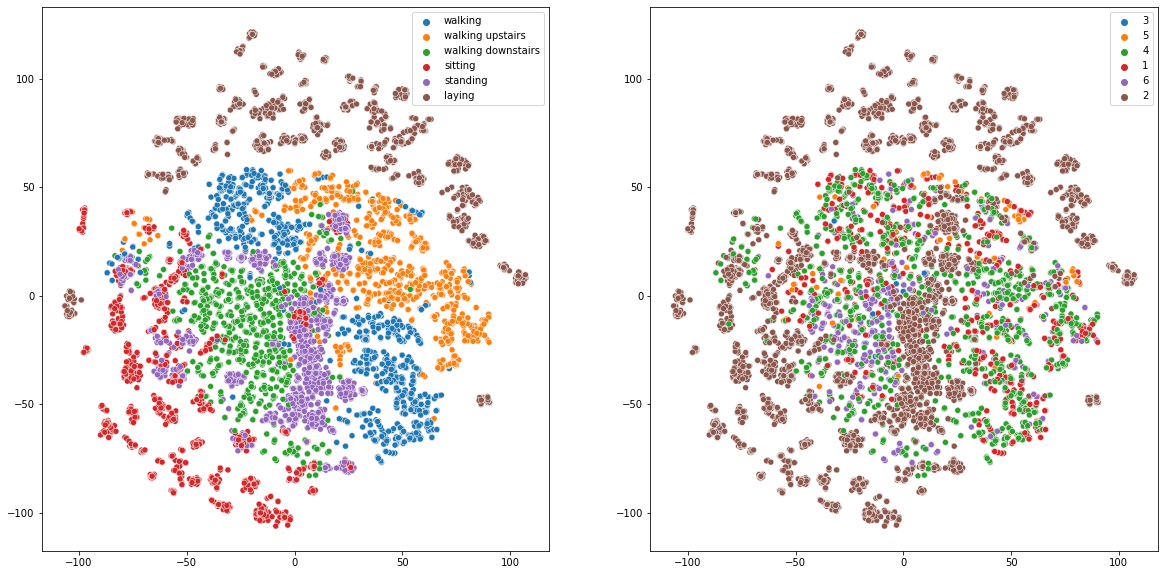

In [67]:
palette = sns.color_palette(n_colors=6)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(data=tsne_transformed, x=tsne_transformed[:,0], y=tsne_transformed[:,1], 
                hue = np.vectorize(activities_description.get)(y_train), 
                hue_order = list(activities_description.values()),
                ax = ax[0],  
                palette=palette);


sns.scatterplot(data=tsne_transformed, x = tsne_transformed[:,0], y=tsne_transformed[:,1], 
                hue = label_dtw_drop+1, 
                ax = ax[1], palette=palette, 
                hue_order = [3,5,4,1,6,2]
               );

In [98]:
label_dtw_drop+1

array([2, 2, 2, ..., 1, 4, 1])

In [99]:
activities_description.values()

dict_values(['walking', 'walking upstairs', 'walking downstairs', 'sitting', 'standing', 'laying'])

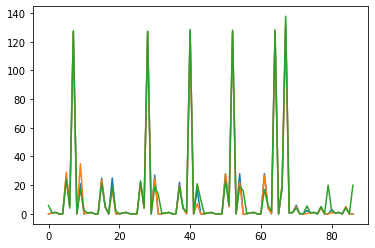

In [101]:
plt.plot(X_train_drop[0])
plt.plot(X_train_drop[3])
plt.plot(X_train_drop[4])

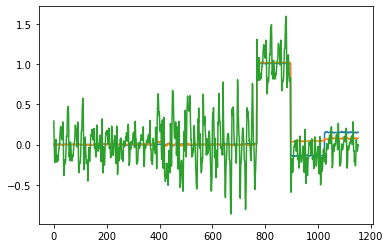

In [104]:
plt.plot(X_train[0])
plt.plot(X_train[3])
plt.plot(X_train[4])